In [46]:
import time
import pickle
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

import copy
from sklearn.ensemble import ExtraTreesRegressor

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, he_normal, he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

In [47]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [48]:
class Process:
    def __init__(self, 
                 X_train, X_test, X_val, y_train, y_test, y_val, 
                 imputer='mean', 
                 minmaxrange=(-1,1), 
                 standardize_X=True,
                 standardize_y=True,
                 robust_range=(10, 90),
                ):
        self.y_process = []
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.y_val = y_val.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.X_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)
            self.X_val[:] = imputer.transform(self.X_val)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        self.X_val[:] = self.X_minmaxscaler.transform(self.X_val)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = self.y_minmaxscaler.transform(self.y_train)
        self.y_test[:] = self.y_minmaxscaler.transform(self.y_test)
        self.y_val[:] = self.y_minmaxscaler.transform(self.y_val)
        self.y_process.append(self.minmaxscale_Y_inverse)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def robustscale_X(self):
        self.X_robust_scaler.fit(self.X_train)
        self.X_train[:] = self.X_robust_scaler.transform(self.X_train)
        self.X_test[:] = self.X_robust_scaler.transform(self.X_test)
        self.X_val[:] = self.X_robust_scaler.transform(self.X_val)
        return self
    
    def robustscale_X_inverse(self, data):
        return self.X_robust_scaler.inverse_transform(data)
    
    def robustscale_Y(self, inverse=False):
        self.y_robust_scaler.fit(self.y_train)
        self.y_train[:] = self.y_robust_scaler.transform(self.y_train)
        self.y_test[:] = self.y_robust_scaler.transform(self.y_test)
        self.y_val[:] = self.y_robust_scaler.transform(self.y_val)
        self.y_process.append(self.robustscale_Y_inverse)
        return self
    
    def robustscale_Y_inverse(self, data): # data is in 1d array
        return self.y_robust_scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        self.X_val[:] = self.skewer_X.transform(self.X_val)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        self.y_val = self.skewer_y.transform(self.y_val)
        self.y_process.append(self.skew_y_inverse)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.X_val, self.y_train.flatten(), self.y_test.flatten(), self.y_val.flatten()      

In [49]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': np.mean(np.abs((y_test - y_pred)/y_test)) * 100,
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]}')
    return res


def predict(model, model_name, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    if len(pred_train.shape) == 2 and pred_train.shape[1] == 1:
        pred_train = pred_train.flatten()
        pred_test = pred_test.flatten()
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def output_metrics(model, data, process, with_val=True):
    if with_val:  
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],
                       data['X_val'],
                       data['y_val'])
    else:
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],  
                       data['X_test'],
                       data['y_test'])

    y_actual_train_back = res['actual']['train']
    y_pred_train_back = res['predictions']['train']
    y_actual_test_back = res['actual']['test']
    y_pred_test_back = res['predictions']['test']
    
    print_sorted_actual_to_predicted_graphs(
        y_actual_train_back,
        y_pred_train_back,
        y_actual_test_back,
        y_pred_test_back)

    if process and process.y_process:
        for apply_function in reversed(process.y_process):
            y_actual_train_back = apply_function(y_actual_train_back)
            y_pred_train_back = apply_function(y_pred_train_back)
            y_actual_test_back = apply_function(y_actual_test_back)
            y_pred_test_back = apply_function(y_pred_test_back)

        print_metrics('train', y_actual_train_back, y_pred_train_back, data['X_train'].shape[1])
        print_metrics('test', y_actual_test_back, y_pred_test_back, data['X_test'].shape[1])
        print_sorted_actual_to_predicted_graphs(
            y_actual_train_back,
            y_pred_train_back,
            y_actual_test_back,
            y_pred_test_back, print_log=True)


def print_graphs(actual, predicted, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(train_real, train_pred, test_real, test_pred, print_log=False):
    if print_log:
        print('train log')
        print_graphs(train_real, train_pred, print_log=True)
        print('test log')
        print_graphs(test_real, test_pred, print_log=True)
    print('train')
    print_graphs(train_real, train_pred)
    print('test')
    print_graphs(test_real, test_pred)
    
# -----------------------------------------

def get_data():
    with open('proc_data_001.pickle', 'rb') as handle:
        d = pickle.load(handle)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        return X_train, y_train, X_test, y_test

In [50]:
path = 'datasets'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
datasets = sorted([d for d in onlyfiles if not 'raw' in d and 'dataset' in d])

In [51]:
datasets

['dataset_all.csv',
 'dataset_budget_start_1percent.csv',
 'dataset_budget_start_5percent.csv',
 'dataset_gb.csv',
 'dataset_profitability_10percentile.csv',
 'dataset_profitability_1percentile.csv',
 'dataset_profitability_1percentile_years2000-2018.csv',
 'dataset_profitability_1percentile_years2000-2018_budget_start_1percent.csv',
 'dataset_profitability_1percentile_years2000-2018_budget_start_5percent.csv',
 'dataset_profitability_5percentile.csv',
 'dataset_profitability_negative.csv',
 'dataset_profitability_positive.csv',
 'dataset_revenue_1percentile.csv',
 'dataset_revenue_5percentile.csv',
 'dataset_us.csv',
 'dataset_years1970-1999.csv',
 'dataset_years2000-2018.csv']

In [52]:
# cols_to_exclude = ['genre__western', 'genre__documentary', 'genre__history', 'country__es', 'country__jp', 'country__ca', 'country__de', 'country__in', 'country__fr', 'country__ru', 'country__it', 'country__au', 'rating__nc-17', 'country__other', 'tag__satire', 'tag__neo_noir', 'tag__sadist', 'tag__cruelty', 'tag__dark', 'tag__storytelling', 'tag__sci_fi', 'tag__psychological', 'tag__absurd', 'tag__philosophical', 'tag__depressing', 'tag__plot_twist', 'tag__realism', 'tag__home_movie', 'tag__thought_provoking']
# cols_to_exclude = [col for col in df.columns if (('budget' in col or 'profit' in col) and ('crew' in col or 'cast' in col))]

def split_process_df(name, train=0.8, test=0.1):
    def get_train_test_revenue(df):
        df['revenue'] = df['META__revenue']
        dff = df[[col for col in df.columns if not 'META' in col]]
        X = dff.drop(['revenue'], axis=1)
        y = dff['revenue']
        return X, y

    df_raw = pd.read_csv(f'datasets/{name}')
    # df_raw = reduce_mem_usage(df_raw)
    df = shuffle(df_raw, random_state=0)

    num_in_train = int(df.shape[0]*0.8)
    # num_in_test = int(df.shape[0]*0.1)
    num_in_test = int(df.shape[0]*0.1)
    df_train = df[:num_in_train].copy()
    df_test = df[num_in_train:num_in_train+num_in_test].copy()
    df_val = df[num_in_train+num_in_test:].copy()
    X_train, y_train = get_train_test_revenue(df_train)
    X_test, y_test = get_train_test_revenue(df_test)
    X_val, y_val = get_train_test_revenue(df_val)
    
    data = {}
    process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_Y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').robustscale_X().robustscale_Y().skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().robustscale_Y().fill_nan()
    data['X_train'], data['X_test'], data['X_val'], data['y_train'], data['y_test'], data['y_val'] = process.return_processed()
    return data, process

In [ ]:
for d_name in datasets:
    name = d_name.replace('.csv', '')
    if 'revenue' in name:
        print(f'processing {name}')
        data, process = split_process_df(d_name, train=0.8, test=0.1)

        with open(f'processed/{name}_data.pickle', 'wb') as handle:
            pickle.dump(data, handle)

        with open(f'processed/{name}_process.pickle', 'wb') as handle:
            pickle.dump(process, handle)

In [54]:
with open('processed/dataset_profitability_1percentile_years2000-2018_budget_start_1percent_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open('processed/dataset_profitability_1percentile_years2000-2018_budget_start_1percent_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

In [10]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [11]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":25, 
            "eval_metric" : 'mse', 
            "eval_set" : [(data['X_test'], data['y_test'])],
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={
    'num_leaves': sp_randint(5, 1000), 
    'max_depth': sp_randint(5, 100),
    'max_bin': sp_randint(100, 1000),
    'min_child_samples': sp_randint(100, 400), 
    'learning_rate': sp_uniform(loc=0.0001, scale=0.0999),
#     'num_iterations': [2500, 5000, 7500, 10000],
    'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
    'min_child_samples': sp_randint(100, 400), 
    'subsample': sp_uniform(loc=0.3, scale=0.5), 
    'colsample_bytree': sp_uniform(loc=0.6, scale=0.3),
    'reg_alpha': sp_uniform(loc=0, scale=5),
    'reg_lambda': sp_randint(1, 50),
    'bagging_fraction': sp_uniform(loc=0.7, scale=0.3),
    'bagging_freq': sp_randint(5, 20),
    'feature_fraction': sp_uniform(loc=0.5, scale=0.5),
    'min_data_in_leaf': sp_randint(1, 500),
    'min_sum_hessian_in_leaf': sp_randint(1, 100),
}

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMRegressor(
    num_threads=12,
    random_state=314, 
    silent=True, 
    n_jobs=-1,
    verbose=4,
    tree_learner='data',
# #     num_leaves=
#     max_depth=-1,
#     learning_rate=0.001,
#     num_iterations=100000,
#     min_child_weight=10,
# #     min_child_samples=
#     subsample=0.4,
#     colsample_bytree=0.73,
#     reg_alpha=3.15,
#     reg_lambda=26,
# #     max_bin=
#     bagging_fraction=0.96,
#     bagging_freq=6,
#     feature_fraction=0.6,
#     min_data_in_leaf=50,
#     min_sum_hessian_in_leaf=50,
)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=1000,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(
    data['X_train'], 
    data['y_train'], 
    **fit_params,
)

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

/home/stastempaccount/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.907944	valid_0's l2: 0.824362
[4]	valid_0's rmse: 0.845301	valid_0's l2: 0.714534
[6]	valid_0's rmse: 0.802569	valid_0's l2: 0.644118
[8]	valid_0's rmse: 0.750927	valid_0's l2: 0.563892
[10]	valid_0's rmse: 0.721087	valid_0's l2: 0.519967
[12]	valid_0's rmse: 0.692024	valid_0's l2: 0.478897
[14]	valid_0's rmse: 0.668312	valid_0's l2: 0.446642
[16]	valid_0's rmse: 0.644739	valid_0's l2: 0.415689
[18]	valid_0's rmse: 0.628719	valid_0's l2: 0.395288
[20]	valid_0's rmse: 0.613063	valid_0's l2: 0.375846
[22]	valid_0's rmse: 0.599862	valid_0's l2: 0.359834
[24]	valid_0's rmse: 0.593361	valid_0's l2: 0.352078
[26]	valid_0's rmse: 0.585179	valid_0's l2: 0.342434
[28]	valid_0's rmse: 0.579413	valid_0's l2: 0.33572
[30]	valid_0's rmse: 0.574238	valid_0's l2: 0.329749
[32]	valid_0's rmse: 0.570071	valid_0's l2: 0.324981
[34]	valid_0's rmse: 0.567808	valid_0's l2: 0.322406
[36]	valid_0's rmse: 0.563798	valid_0's l2

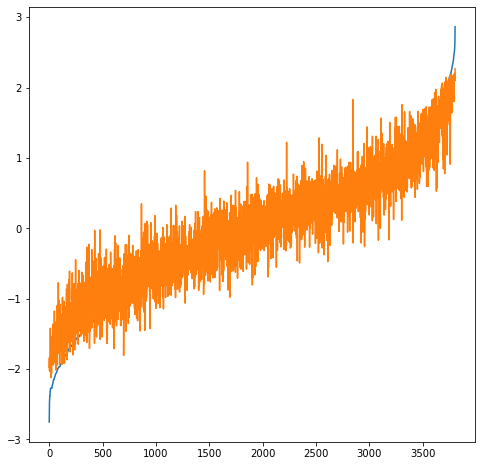

test


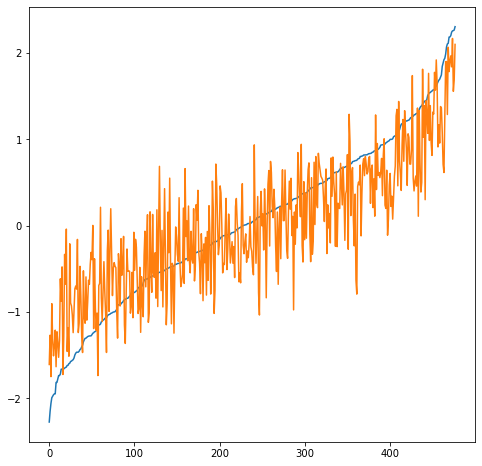

train
mape: 124.37408497260216
mae: 30420976.687145967
rmse: 74422190.77990352
adj_r2: 0.8029595307667519
test
mape: 244.366219188501
mae: 44663967.55229508
rmse: 92671783.75083591
adj_r2: 0.392076813949192
train log


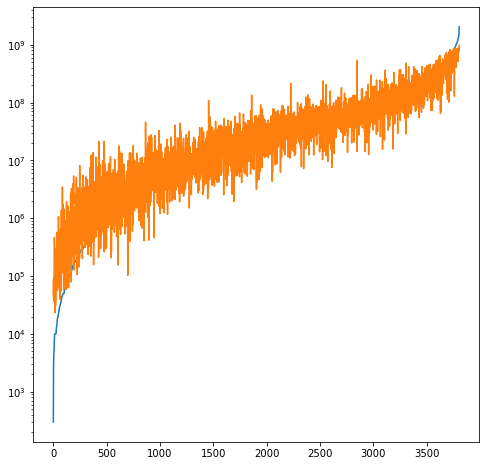

test log


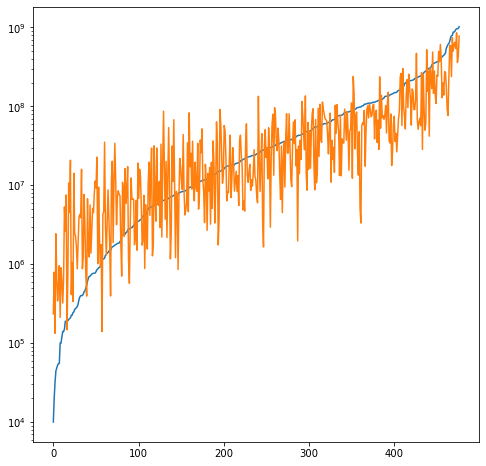

train


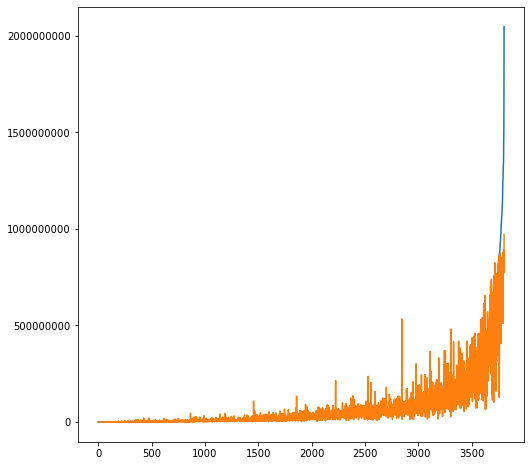

test


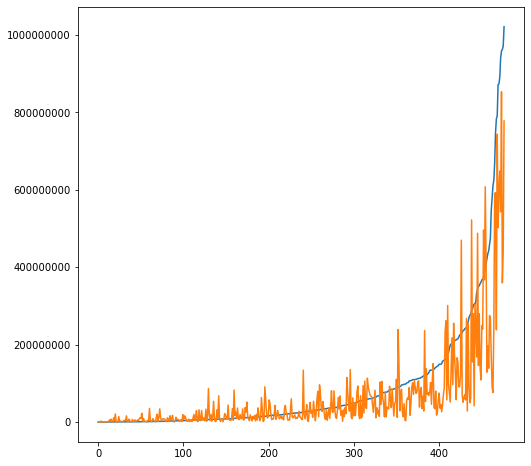

In [55]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
#     boosting='dart',
    num_iterations=50000,
    objective='regression',
    bagging_fraction=0.937,
    bagging_freq=14, 
    colsample_bytree=0.609,
    feature_fraction=0.626,
    learning_rate=0.086, 
    max_bin=117,
    max_depth=74,
    min_child_samples=169,
    min_child_weight=0.01,
    min_data_in_leaf=72, 
    min_sum_hessian_in_leaf=34,
#     n_estimators=2500,
    num_leaves=411,
    reg_alpha=0.5,
    reg_lambda=44,
    subsample=0.63,
    feature_fraction_seed=9,
    bagging_seed=9,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=2,
    eval_metric='rmse',
    eval_set=(data['X_test'], data['y_test']),
    early_stopping_rounds=100,
)
output_metrics(mod_lgb, data, process, with_val=True)

Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 0.99562
[4]	valid_0's l2: 0.993272
[6]	valid_0's l2: 0.991251
[8]	valid_0's l2: 0.988917
[10]	valid_0's l2: 0.986927
[12]	valid_0's l2: 0.984951
[14]	valid_0's l2: 0.982977
[16]	valid_0's l2: 0.981253
[18]	valid_0's l2: 0.978952
[20]	valid_0's l2: 0.976661
[22]	valid_0's l2: 0.974383
[24]	valid_0's l2: 0.972412
[26]	valid_0's l2: 0.970153
[28]	valid_0's l2: 0.967907
[30]	valid_0's l2: 0.965938
[32]	valid_0's l2: 0.963634
[34]	valid_0's l2: 0.961338
[36]	valid_0's l2: 0.959049
[38]	valid_0's l2: 0.956763
[40]	valid_0's l2: 0.9545
[42]	valid_0's l2: 0.952233
[44]	valid_0's l2: 0.949972
[46]	valid_0's l2: 0.947765
[48]	valid_0's l2: 0.945562
[50]	valid_0's l2: 0.943908
[52]	valid_0's l2: 0.941678
[54]	valid_0's l2: 0.93947
[56]	valid_0's l2: 0.937262
[58]	valid_0's l2: 0.935097
[60]	valid_0's l2: 0.932926
[62]	valid_0's l2: 0.931097
[64]	valid_0's l2: 0.9293
[66]	valid_0's l2: 0.927466
[68]	valid_0's l2: 0.9253

[640]	valid_0's l2: 0.557382
[642]	valid_0's l2: 0.556574
[644]	valid_0's l2: 0.555787
[646]	valid_0's l2: 0.555069
[648]	valid_0's l2: 0.55422
[650]	valid_0's l2: 0.553374
[652]	valid_0's l2: 0.552568
[654]	valid_0's l2: 0.551758
[656]	valid_0's l2: 0.551039
[658]	valid_0's l2: 0.550237
[660]	valid_0's l2: 0.549531
[662]	valid_0's l2: 0.548721
[664]	valid_0's l2: 0.547905
[666]	valid_0's l2: 0.547109
[668]	valid_0's l2: 0.546314
[670]	valid_0's l2: 0.545543
[672]	valid_0's l2: 0.54486
[674]	valid_0's l2: 0.544065
[676]	valid_0's l2: 0.543303
[678]	valid_0's l2: 0.542624
[680]	valid_0's l2: 0.54195
[682]	valid_0's l2: 0.541191
[684]	valid_0's l2: 0.540531
[686]	valid_0's l2: 0.539854
[688]	valid_0's l2: 0.539165
[690]	valid_0's l2: 0.538423
[692]	valid_0's l2: 0.537682
[694]	valid_0's l2: 0.536941
[696]	valid_0's l2: 0.536288
[698]	valid_0's l2: 0.535542
[700]	valid_0's l2: 0.534803
[702]	valid_0's l2: 0.534061
[704]	valid_0's l2: 0.533421
[706]	valid_0's l2: 0.532801
[708]	valid_0's l

[1274]	valid_0's l2: 0.401466
[1276]	valid_0's l2: 0.401154
[1278]	valid_0's l2: 0.400871
[1280]	valid_0's l2: 0.400557
[1282]	valid_0's l2: 0.40026
[1284]	valid_0's l2: 0.399988
[1286]	valid_0's l2: 0.399678
[1288]	valid_0's l2: 0.399391
[1290]	valid_0's l2: 0.399144
[1292]	valid_0's l2: 0.398917
[1294]	valid_0's l2: 0.398671
[1296]	valid_0's l2: 0.398387
[1298]	valid_0's l2: 0.398109
[1300]	valid_0's l2: 0.39784
[1302]	valid_0's l2: 0.397544
[1304]	valid_0's l2: 0.397269
[1306]	valid_0's l2: 0.396988
[1308]	valid_0's l2: 0.396722
[1310]	valid_0's l2: 0.39648
[1312]	valid_0's l2: 0.396232
[1314]	valid_0's l2: 0.395956
[1316]	valid_0's l2: 0.395682
[1318]	valid_0's l2: 0.395425
[1320]	valid_0's l2: 0.395146
[1322]	valid_0's l2: 0.394891
[1324]	valid_0's l2: 0.39464
[1326]	valid_0's l2: 0.394346
[1328]	valid_0's l2: 0.394057
[1330]	valid_0's l2: 0.393769
[1332]	valid_0's l2: 0.39348
[1334]	valid_0's l2: 0.393195
[1336]	valid_0's l2: 0.392959
[1338]	valid_0's l2: 0.392688
[1340]	valid_0'

[1898]	valid_0's l2: 0.341825
[1900]	valid_0's l2: 0.341729
[1902]	valid_0's l2: 0.341622
[1904]	valid_0's l2: 0.341519
[1906]	valid_0's l2: 0.341397
[1908]	valid_0's l2: 0.341278
[1910]	valid_0's l2: 0.341167
[1912]	valid_0's l2: 0.341035
[1914]	valid_0's l2: 0.340908
[1916]	valid_0's l2: 0.340804
[1918]	valid_0's l2: 0.340695
[1920]	valid_0's l2: 0.340593
[1922]	valid_0's l2: 0.340445
[1924]	valid_0's l2: 0.340364
[1926]	valid_0's l2: 0.340221
[1928]	valid_0's l2: 0.340093
[1930]	valid_0's l2: 0.339956
[1932]	valid_0's l2: 0.339845
[1934]	valid_0's l2: 0.339707
[1936]	valid_0's l2: 0.339612
[1938]	valid_0's l2: 0.339502
[1940]	valid_0's l2: 0.339403
[1942]	valid_0's l2: 0.339304
[1944]	valid_0's l2: 0.339192
[1946]	valid_0's l2: 0.339099
[1948]	valid_0's l2: 0.338989
[1950]	valid_0's l2: 0.338874
[1952]	valid_0's l2: 0.33874
[1954]	valid_0's l2: 0.338602
[1956]	valid_0's l2: 0.338458
[1958]	valid_0's l2: 0.338343
[1960]	valid_0's l2: 0.338223
[1962]	valid_0's l2: 0.338145
[1964]	vali

[2490]	valid_0's l2: 0.31778
[2492]	valid_0's l2: 0.317727
[2494]	valid_0's l2: 0.317675
[2496]	valid_0's l2: 0.317616
[2498]	valid_0's l2: 0.317559
[2500]	valid_0's l2: 0.317495
[2502]	valid_0's l2: 0.317447
[2504]	valid_0's l2: 0.317405
[2506]	valid_0's l2: 0.317348
[2508]	valid_0's l2: 0.317291
[2510]	valid_0's l2: 0.317219
[2512]	valid_0's l2: 0.317142
[2514]	valid_0's l2: 0.317073
[2516]	valid_0's l2: 0.316997
[2518]	valid_0's l2: 0.316948
[2520]	valid_0's l2: 0.316892
[2522]	valid_0's l2: 0.31684
[2524]	valid_0's l2: 0.316783
[2526]	valid_0's l2: 0.316734
[2528]	valid_0's l2: 0.316681
[2530]	valid_0's l2: 0.316606
[2532]	valid_0's l2: 0.316542
[2534]	valid_0's l2: 0.316489
[2536]	valid_0's l2: 0.316428
[2538]	valid_0's l2: 0.316394
[2540]	valid_0's l2: 0.316351
[2542]	valid_0's l2: 0.316302
[2544]	valid_0's l2: 0.316248
[2546]	valid_0's l2: 0.316192
[2548]	valid_0's l2: 0.316148
[2550]	valid_0's l2: 0.3161
[2552]	valid_0's l2: 0.316052
[2554]	valid_0's l2: 0.315999
[2556]	valid_0

[3068]	valid_0's l2: 0.305788
[3070]	valid_0's l2: 0.305758
[3072]	valid_0's l2: 0.305728
[3074]	valid_0's l2: 0.305701
[3076]	valid_0's l2: 0.305668
[3078]	valid_0's l2: 0.305625
[3080]	valid_0's l2: 0.305596
[3082]	valid_0's l2: 0.305566
[3084]	valid_0's l2: 0.305543
[3086]	valid_0's l2: 0.305524
[3088]	valid_0's l2: 0.305492
[3090]	valid_0's l2: 0.305466
[3092]	valid_0's l2: 0.305444
[3094]	valid_0's l2: 0.305417
[3096]	valid_0's l2: 0.305383
[3098]	valid_0's l2: 0.305358
[3100]	valid_0's l2: 0.305325
[3102]	valid_0's l2: 0.305305
[3104]	valid_0's l2: 0.305265
[3106]	valid_0's l2: 0.305247
[3108]	valid_0's l2: 0.30521
[3110]	valid_0's l2: 0.30519
[3112]	valid_0's l2: 0.305158
[3114]	valid_0's l2: 0.305127
[3116]	valid_0's l2: 0.305091
[3118]	valid_0's l2: 0.305077
[3120]	valid_0's l2: 0.305049
[3122]	valid_0's l2: 0.30503
[3124]	valid_0's l2: 0.304989
[3126]	valid_0's l2: 0.304967
[3128]	valid_0's l2: 0.304935
[3130]	valid_0's l2: 0.30489
[3132]	valid_0's l2: 0.304846
[3134]	valid_0

[3622]	valid_0's l2: 0.299609
[3624]	valid_0's l2: 0.299606
[3626]	valid_0's l2: 0.299603
[3628]	valid_0's l2: 0.299574
[3630]	valid_0's l2: 0.299569
[3632]	valid_0's l2: 0.299563
[3634]	valid_0's l2: 0.29954
[3636]	valid_0's l2: 0.299514
[3638]	valid_0's l2: 0.299496
[3640]	valid_0's l2: 0.299473
[3642]	valid_0's l2: 0.29947
[3644]	valid_0's l2: 0.299461
[3646]	valid_0's l2: 0.299453
[3648]	valid_0's l2: 0.299434
[3650]	valid_0's l2: 0.299413
[3652]	valid_0's l2: 0.299402
[3654]	valid_0's l2: 0.299372
[3656]	valid_0's l2: 0.299351
[3658]	valid_0's l2: 0.299354
[3660]	valid_0's l2: 0.299324
[3662]	valid_0's l2: 0.299297
[3664]	valid_0's l2: 0.29928
[3666]	valid_0's l2: 0.29926
[3668]	valid_0's l2: 0.299252
[3670]	valid_0's l2: 0.299248
[3672]	valid_0's l2: 0.299241
[3674]	valid_0's l2: 0.299228
[3676]	valid_0's l2: 0.299213
[3678]	valid_0's l2: 0.299184
[3680]	valid_0's l2: 0.299179
[3682]	valid_0's l2: 0.299158
[3684]	valid_0's l2: 0.299143
[3686]	valid_0's l2: 0.299126
[3688]	valid_0

[4180]	valid_0's l2: 0.296579
[4182]	valid_0's l2: 0.296572
[4184]	valid_0's l2: 0.296552
[4186]	valid_0's l2: 0.29654
[4188]	valid_0's l2: 0.296521
[4190]	valid_0's l2: 0.296503
[4192]	valid_0's l2: 0.296492
[4194]	valid_0's l2: 0.296475
[4196]	valid_0's l2: 0.296474
[4198]	valid_0's l2: 0.29647
[4200]	valid_0's l2: 0.296466
[4202]	valid_0's l2: 0.296466
[4204]	valid_0's l2: 0.296464
[4206]	valid_0's l2: 0.296453
[4208]	valid_0's l2: 0.296436
[4210]	valid_0's l2: 0.296421
[4212]	valid_0's l2: 0.296416
[4214]	valid_0's l2: 0.296409
[4216]	valid_0's l2: 0.296394
[4218]	valid_0's l2: 0.296379
[4220]	valid_0's l2: 0.296361
[4222]	valid_0's l2: 0.296346
[4224]	valid_0's l2: 0.296329
[4226]	valid_0's l2: 0.296298
[4228]	valid_0's l2: 0.29627
[4230]	valid_0's l2: 0.29625
[4232]	valid_0's l2: 0.296229
[4234]	valid_0's l2: 0.296191
[4236]	valid_0's l2: 0.296187
[4238]	valid_0's l2: 0.296156
[4240]	valid_0's l2: 0.296133
[4242]	valid_0's l2: 0.296109
[4244]	valid_0's l2: 0.296091
[4246]	valid_0

[4768]	valid_0's l2: 0.293629
[4770]	valid_0's l2: 0.293621
[4772]	valid_0's l2: 0.293619
[4774]	valid_0's l2: 0.293608
[4776]	valid_0's l2: 0.293596
[4778]	valid_0's l2: 0.293591
[4780]	valid_0's l2: 0.293583
[4782]	valid_0's l2: 0.293577
[4784]	valid_0's l2: 0.293572
[4786]	valid_0's l2: 0.293572
[4788]	valid_0's l2: 0.293571
[4790]	valid_0's l2: 0.293581
[4792]	valid_0's l2: 0.293572
[4794]	valid_0's l2: 0.293567
[4796]	valid_0's l2: 0.293567
[4798]	valid_0's l2: 0.293559
[4800]	valid_0's l2: 0.293565
[4802]	valid_0's l2: 0.293565
[4804]	valid_0's l2: 0.29356
[4806]	valid_0's l2: 0.293554
[4808]	valid_0's l2: 0.293559
[4810]	valid_0's l2: 0.293561
[4812]	valid_0's l2: 0.293561
[4814]	valid_0's l2: 0.293575
[4816]	valid_0's l2: 0.293571
[4818]	valid_0's l2: 0.29357
[4820]	valid_0's l2: 0.293551
[4822]	valid_0's l2: 0.293545
[4824]	valid_0's l2: 0.293523
[4826]	valid_0's l2: 0.293513
[4828]	valid_0's l2: 0.293485
[4830]	valid_0's l2: 0.293468
[4832]	valid_0's l2: 0.293465
[4834]	valid

[5340]	valid_0's l2: 0.29195
[5342]	valid_0's l2: 0.291943
[5344]	valid_0's l2: 0.291936
[5346]	valid_0's l2: 0.291929
[5348]	valid_0's l2: 0.291917
[5350]	valid_0's l2: 0.291908
[5352]	valid_0's l2: 0.291904
[5354]	valid_0's l2: 0.2919
[5356]	valid_0's l2: 0.29189
[5358]	valid_0's l2: 0.291876
[5360]	valid_0's l2: 0.291861
[5362]	valid_0's l2: 0.29186
[5364]	valid_0's l2: 0.291847
[5366]	valid_0's l2: 0.291829
[5368]	valid_0's l2: 0.29182
[5370]	valid_0's l2: 0.291814
[5372]	valid_0's l2: 0.291812
[5374]	valid_0's l2: 0.291793
[5376]	valid_0's l2: 0.291775
[5378]	valid_0's l2: 0.291769
[5380]	valid_0's l2: 0.291766
[5382]	valid_0's l2: 0.291766
[5384]	valid_0's l2: 0.291758
[5386]	valid_0's l2: 0.29174
[5388]	valid_0's l2: 0.291719
[5390]	valid_0's l2: 0.291703
[5392]	valid_0's l2: 0.291706
[5394]	valid_0's l2: 0.291704
[5396]	valid_0's l2: 0.291708
[5398]	valid_0's l2: 0.291697
[5400]	valid_0's l2: 0.291687
[5402]	valid_0's l2: 0.291672
[5404]	valid_0's l2: 0.291679
[5406]	valid_0's 

[5946]	valid_0's l2: 0.290664
[5948]	valid_0's l2: 0.290665
[5950]	valid_0's l2: 0.290665
[5952]	valid_0's l2: 0.290668
[5954]	valid_0's l2: 0.290676
[5956]	valid_0's l2: 0.290682
[5958]	valid_0's l2: 0.290687
[5960]	valid_0's l2: 0.290671
[5962]	valid_0's l2: 0.290662
[5964]	valid_0's l2: 0.290664
[5966]	valid_0's l2: 0.290656
[5968]	valid_0's l2: 0.290663
[5970]	valid_0's l2: 0.290651
[5972]	valid_0's l2: 0.290652
[5974]	valid_0's l2: 0.290653
[5976]	valid_0's l2: 0.290653
[5978]	valid_0's l2: 0.290654
[5980]	valid_0's l2: 0.290651
[5982]	valid_0's l2: 0.290651
[5984]	valid_0's l2: 0.290647
[5986]	valid_0's l2: 0.290659
[5988]	valid_0's l2: 0.290657
[5990]	valid_0's l2: 0.290658
[5992]	valid_0's l2: 0.290655
[5994]	valid_0's l2: 0.290648
[5996]	valid_0's l2: 0.290658
[5998]	valid_0's l2: 0.290668
[6000]	valid_0's l2: 0.290671
[6002]	valid_0's l2: 0.290663
[6004]	valid_0's l2: 0.290662
[6006]	valid_0's l2: 0.290664
[6008]	valid_0's l2: 0.290654
[6010]	valid_0's l2: 0.290639
[6012]	val

[6514]	valid_0's l2: 0.290064
[6516]	valid_0's l2: 0.290064
[6518]	valid_0's l2: 0.290074
[6520]	valid_0's l2: 0.290071
[6522]	valid_0's l2: 0.290076
[6524]	valid_0's l2: 0.290081
[6526]	valid_0's l2: 0.290075
[6528]	valid_0's l2: 0.29008
[6530]	valid_0's l2: 0.290075
[6532]	valid_0's l2: 0.290074
[6534]	valid_0's l2: 0.29007
[6536]	valid_0's l2: 0.290064
[6538]	valid_0's l2: 0.29006
[6540]	valid_0's l2: 0.290073
[6542]	valid_0's l2: 0.290076
[6544]	valid_0's l2: 0.29008
[6546]	valid_0's l2: 0.290077
[6548]	valid_0's l2: 0.290073
[6550]	valid_0's l2: 0.290073
[6552]	valid_0's l2: 0.290076
[6554]	valid_0's l2: 0.290077
[6556]	valid_0's l2: 0.290071
[6558]	valid_0's l2: 0.290079
[6560]	valid_0's l2: 0.290075
[6562]	valid_0's l2: 0.290076
[6564]	valid_0's l2: 0.290085
[6566]	valid_0's l2: 0.290081
[6568]	valid_0's l2: 0.290079
[6570]	valid_0's l2: 0.290077
[6572]	valid_0's l2: 0.290082
[6574]	valid_0's l2: 0.290083
[6576]	valid_0's l2: 0.290082
[6578]	valid_0's l2: 0.29008
[6580]	valid_0'

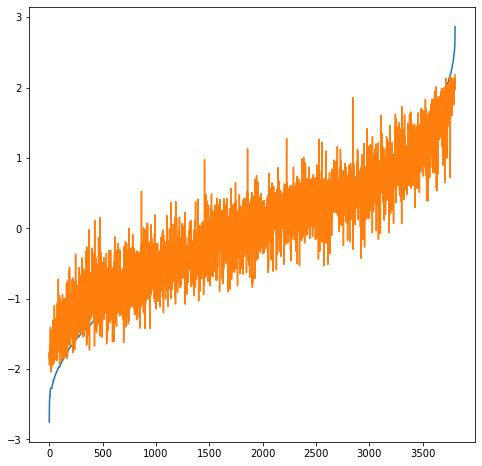

test


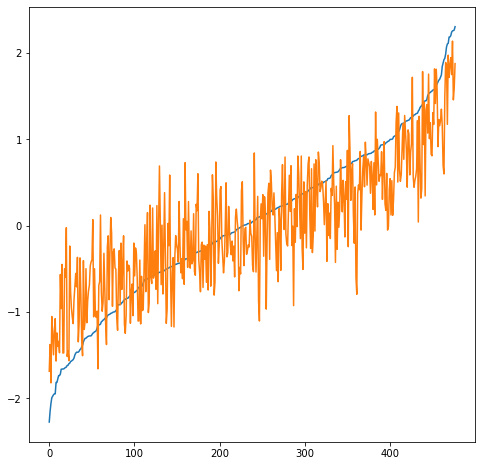

train
mape: 152.59383120267074
mae: 33226255.87024733
rmse: 81616819.3598718
adj_r2: 0.7630209987669695
test
mape: 239.2253292163639
mae: 46193543.66263168
rmse: 97047676.7590853
adj_r2: 0.333309987472194
train log


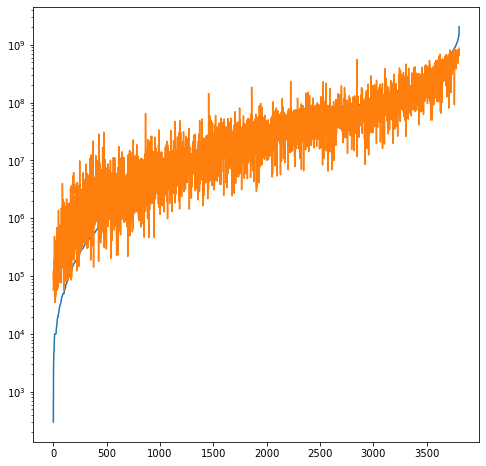

test log


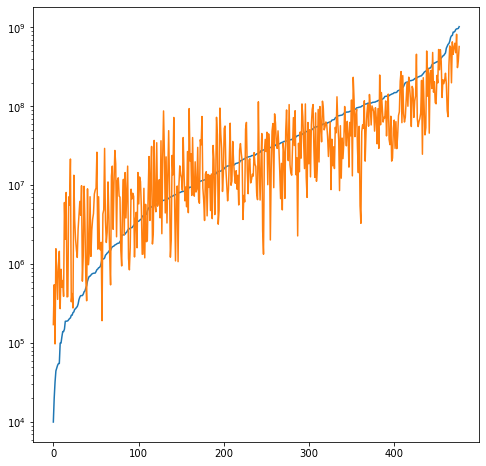

train


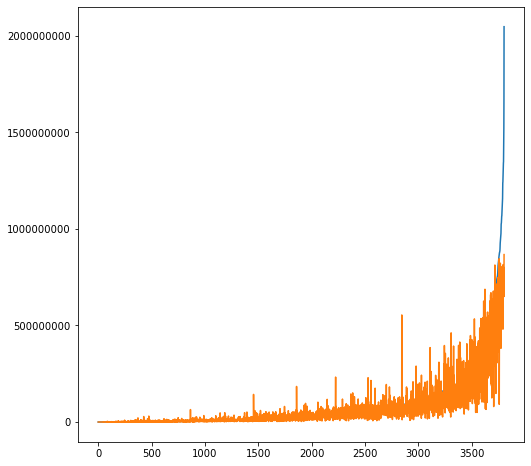

test


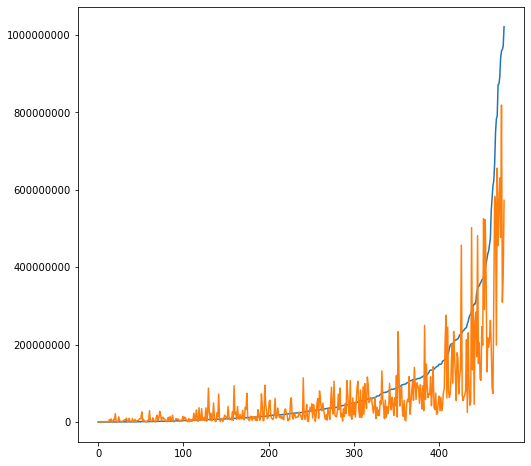

In [56]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=34,
    learning_rate=0.001, 
    n_estimators=7500,
    max_bin=192,
    max_depth=0,
    min_child_samples=160,
    min_child_weight=0.001,
    bagging_fraction=0.98,
    bagging_freq=15, 
    feature_fraction=0.77,
    metric='l2',
    bagging_seed=9,
    min_data_in_leaf=1, 
    min_sum_hessian_in_leaf=50,
    colsample_bytree=0.87,
    reg_alpha=0.18,
    reg_lambda=30,
    subsample=0.39,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=2,
    eval_metric='mse',
    eval_set=[(data['X_test'], data['y_test'])],
    early_stopping_rounds=50
)
output_metrics(mod_lgb, data, process, with_val=True)

In [ ]:
param_test_etr ={
    'n_estimators': [100, 500, 750, 1000, 5000, 10000],
    'max_depth': sp_randint(1, 200),
    'max_features': sp_randint(10, 225), 
    'min_samples_leaf': sp_randint(1,50), 
    'min_samples_split': sp_randint(1,50),
    'min_weight_fraction_leaf': sp_uniform(0.0, 0.5),
    'max_leaf_nodes': sp_randint(1, 200),
    'min_impurity_decrease': sp_uniform(0.0, 5),
    'ccp_alpha': sp_uniform(0.0, 5),
}

In [ ]:
reg_etr = ExtraTreesRegressor(
    n_jobs=-1, 
    random_state=0,
    verbose=5,
)
reg_etr_gs = RandomizedSearchCV(
    n_jobs=-1, 
    estimator=reg_etr, 
    param_distributions=param_test_etr, 
    n_iter=10,
    cv=5,
    refit=True,
    random_state=314,
    verbose=10)

In [ ]:
%%time

reg_etr_gs.fit(data['X_train'], data['y_train'])

In [ ]:
print('Best score reached: {} with params: {} '.format(reg_etr_gs.best_score_, reg_etr_gs.best_params_))

In [ ]:
etr = ExtraTreesRegressor(
    n_jobs=-1, 
    ccp_alpha=0.32,
    max_depth=10,
    max_features=71, 
    max_leaf_nodes=55,
    min_impurity_decrease=0.35,
    min_samples_leaf=8, 
    min_samples_split=23,
    min_weight_fraction_leaf=0.29,
    n_estimators=5000, 
    
)
etr.fit(data['X_train'].values, data['y_train'])
output_metrics(etr, data, process, with_val=True)

In [ ]:
def model(X_train, y_train, X_test, y_test):
    
    model = tf.keras.Sequential()
    model.add(Dense(
        {{choice([128, 192, 256, 512, 1024, 2048])}}, 
        input_shape=[X_train.shape[1]],
        kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
        bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
        kernel_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        bias_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        activity_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}})))
    model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
    if {{choice(['bn1_yes', 'bn1_no'])}} == 'bn1_yes':
        model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(
        {{choice([128, 192, 256, 512, 1024, 2048])}},
        kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
        bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},          
        kernel_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        bias_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        activity_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}})))
    model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
    if {{choice(['bn2_yes', 'bn2_no'])}} == 'bn2_yes':
        model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(1))
    
    adamax = keras.optimizers.Adamax(
        learning_rate={{uniform(0.001, 0.1)}},
        beta_1={{uniform(0.75, 1)}},
        beta_2={{uniform(0.75, 1)}})
        
    model.compile(loss='mse', 
                  metrics=['mae'],
                  optimizer=adamax)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model.fit(X_train, y_train,
              batch_size={{choice([16, 32, 64, 128, 256, 512])}},
              epochs=500,
              verbose=2,
              validation_data=(X_test, y_test),
#               validation_split=0.15,
              callbacks=[es])

    mse, mae = model.evaluate(X_test, y_test, verbose=1)
    print('Test mse:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

# def model(X_train, y_train, X_test, y_test):
    
#     model = tf.keras.Sequential()
#     model.add(Dense(
#         256,
#         activation='sigmoid', 
#         input_shape=[X_train.shape[1]],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)))        
#     model.add(Dropout(0.005))
#     model.add(Dense(
#         256,
#         activation='sigmoid',
#         kernel_initializer='glorot_normal', 
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
#     model.add(Dropout(0.5))
        
#     model.add(Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     ))
    
#     adamax = keras.optimizers.Adamax(
#         learning_rate=0.001,
#         beta_1={{uniform(0.9, 1)}},
#         beta_2={{uniform(0.9, 1)}})
        
#     model.compile(loss='mse', 
#                   metrics=['mae'],
#                   optimizer=adamax)

#     es = EarlyStopping(
#         monitor='val_loss', 
#         mode='min', 
#         verbose=1, 
#         patience=20)

#     model.fit(X_train, y_train,
#               batch_size=256,
#               epochs=500,
#               verbose=2,
#               shuffle=True,
#               validation_data=(X_test, y_test),
# #               validation_split=0.15,
#               callbacks=[es])
    
#     mse, mae = model.evaluate(X_test, y_test, verbose=1)
#     print('Test mse:', mse)
#     return {'loss': mse, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=trials,
                                      notebook_name='keras',
                                      eval_space=True,
                                      return_space=True)

In [ ]:
best_run

In [ ]:
output_metrics(best_model, data, process)

In [57]:
adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)

def build_model():
  model = tf.keras.Sequential([
    Dense(
        256, 
        activation='sigmoid', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
    ),
    Dropout(0.005),
    Dense(
        256, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    )
  ])

  model.compile(loss='mse',
                optimizer=adamax,
                metrics=['mae', 'mse'])
  return model

model3 = build_model()
# model3.summary()

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20)

history = model3.fit(
    data['X_train'], data['y_train'],
    epochs=10000, 
    validation_data=(data['X_test'], data['y_test']),
    verbose=0,
    batch_size=256,
    shuffle=True,
    callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


Epoch: 0, loss:1.9702,  mae:0.9408,  mse:1.3848,  val_loss:1.1486,  val_mae:0.5758,  val_mse:0.5661,  
....................................................................................................
Epoch: 100, loss:0.3586,  mae:0.4200,  mse:0.2932,  val_loss:0.3527,  val_mae:0.4151,  val_mse:0.2874,  
.....................................................................Epoch 00169: early stopping


train
mape: 192.15676851641646
mae: 0.3976363986331136
rmse: 0.5170101502526477
adj_r2: 0.7158868655982291
test
mape: 190.5082623077886
mae: 0.4131384316690692
rmse: 0.5278639256695569
adj_r2: 0.4261883699319945
train


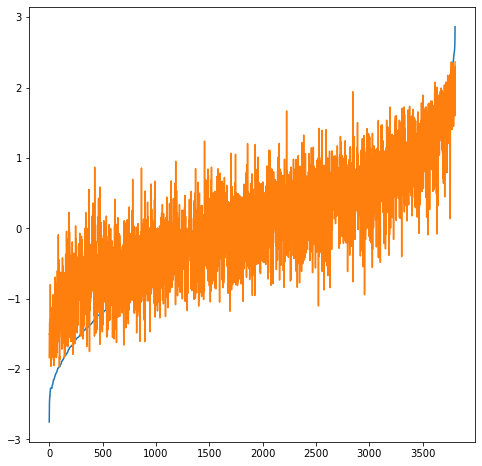

test


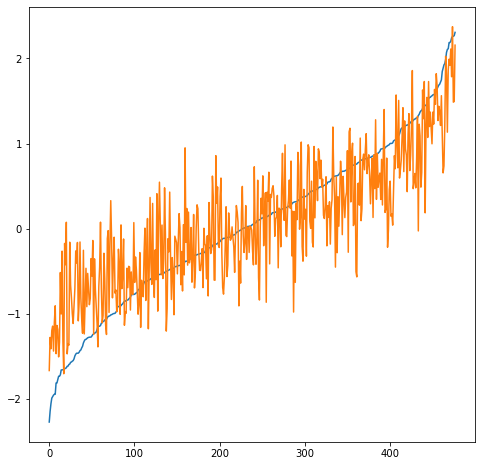

train
mape: 428.07453013133045
mae: 40679786.311784096
rmse: 90667446.886581
adj_r2: 0.7075488687514031
test
mape: 297.67884982682176
mae: 44933941.40844934
rmse: 92961903.88400319
adj_r2: 0.3882645029426637
train log


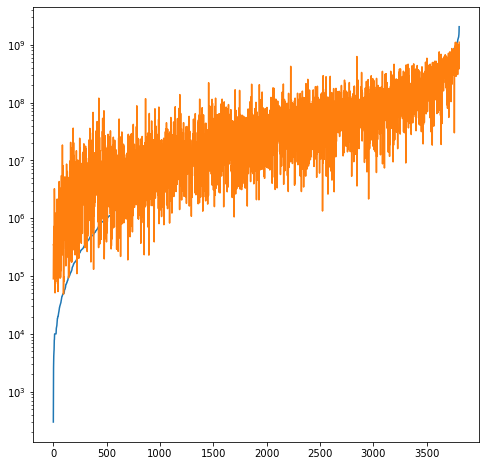

test log


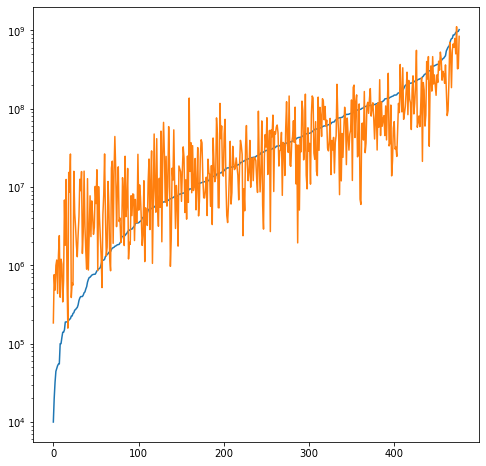

train


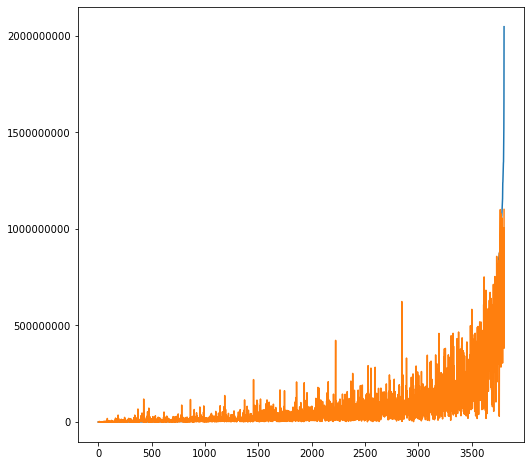

test


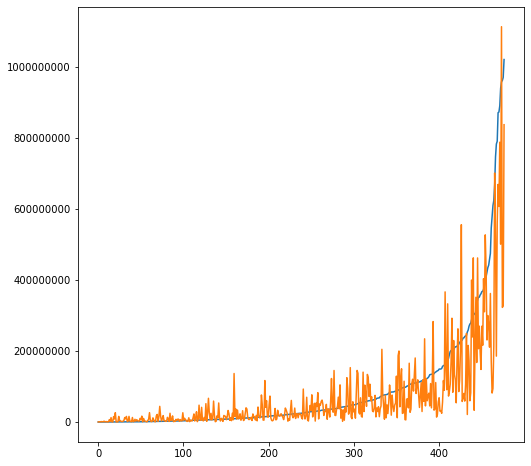

In [58]:
output_metrics(model3, data, process, with_val=True)

In [ ]:
mape: 701.1628654644568
mae: 41859822.98122131
rmse: 92053624.95453802
adj_r2: 0.44188860358712956

In [ ]:
output_metrics(model3, data, process, with_val=True)

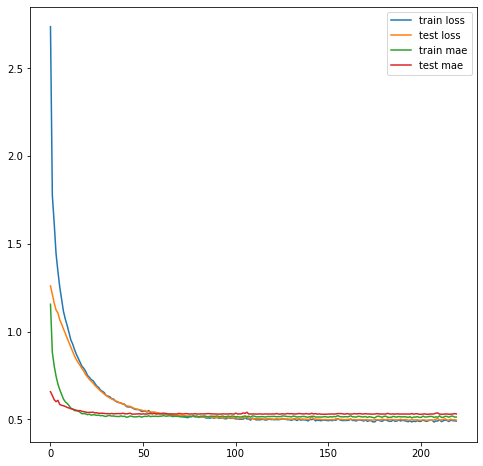

In [45]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.plot(history.history['mae'], label='train mae')
pyplot.plot(history.history['val_mae'], label='test mae')
pyplot.legend()
pyplot.show()

In [ ]:
# relu wo initialization

# mape: 6.6013761902604395
# mae: 47785029.21390841
# rmse: 117085745.28254725
# adj_r2: 0.2683608578800275

In [ ]:
# sigmoid

# mape: 6.921294519771364
# mae: 46309187.6036963
# rmse: 106573312.92760979
# adj_r2: 0.39384203627853387

In [ ]:
# sigmoid initialization glorot

# mape: 5.891309178898037
# mae: 45178191.806934245
# rmse: 105538830.70659108
# adj_r2: 0.40555259042845115

In [ ]:
# relu initialization he-normal

# mape: 11.22876428439224
# mae: 49985922.89351641
# rmse: 124054429.88760668
# adj_r2: 0.1786780362328163

In [ ]:
# {'Dense': 1024,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.15106219282775246,
#  'Dropout_1': 0.6763508226311498,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.30987873188582754,
#  'batch_size': 256,
#  'choiceval': 'adam',
#  'lr': 0.001,
#  'lr_1': 0.01,
#  'lr_2': 0.1}

# mape: 14.735849474528678
# mae: 42425257.59364493
# rmse: 93314406.47801651
# adj_r2: 0.5986823964694081

In [ ]:
# {'Dense': 256,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.2974750265433348,
#  'Dropout_1': 0.39966419778642664,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.526026582745637,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 128,
#  'epochs': 75,
#  'kernel_initializer': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b393ae710>,
#  'kernel_initializer_1': <tensorflow.python.ops.init_ops_v2.GlorotUniform at 0x7f8b393f3610>,
#  'kernel_initializer_2': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b2aec9750>,
#  'optimizer': 'adam'}

# mape: 11.930947077248565
# mae: 41936947.39355901
# rmse: 94227681.26787286
# adj_r2: 0.5117092256416581

In [ ]:
# {'Dense': 256,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.12206225819915595,
#  'Dropout_1': 0.197064731659927,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.00029842311592569865,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'relu',
#  'batch_size': 128,
#  'epochs': 25,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'glorot_normal',
#  'kernel_initializer_2': 'glorot_uniform',
#  'optimizer': 'adam'}

# mape: 6.224157960480135
# mae: 43643280.72317956
# rmse: 99891850.23558912
# adj_r2: 0.5618906445214958

In [ ]:
# {'Dense': 512,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.003154114487844459,
#  'Dropout_1': 0.49453988643233404,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.6057457357612506,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 512,
#  'epochs': 100,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'he_uniform',
#  'kernel_initializer_2': 'glorot_normal',
#  'optimizer': 'adam'}


# mape: 5.984611554637821
# mae: 43830607.21558445
# rmse: 99151995.47327316
# adj_r2: 0.5683563756398305

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         512, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         1024, 
#         activation='sigmoid',
#         kernel_initializer='he_uniform',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#         activity_regularizer=l1_l2(l1=0, l2=0.00001)
#     ),
#     Dropout(0.7), 
#     Dense(1)
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# model3.summary()

# mape: 8.161095980091112
# mae: 35879531.109611064
# rmse: 87476559.6580578
# adj_r2: 0.5608763424966564

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(1)
#   ])

#   model.compile(loss='mae',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=50)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=10000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=1,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


# mape: 5.821131932635737
# mae: 42307258.2010261
# rmse: 95281127.2382761
# adj_r2: 0.4884981254695354

In [ ]:
# skew x -> skew y

# adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     )
#   ])

#   model.compile(loss='mse',
#                 optimizer=adamax,
#                 metrics=['mae', 'mse'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=20)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=1000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=0,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])

# mape: 6.094501890528896
# mae: 40504269.625439286
# rmse: 87054173.39806816
# adj_r2: 0.5730149701057303

In [ ]:
# # skew x -> skew y

# import lightgbm as lgb
# mod_lgb = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=34,
#     learning_rate=0.001, 
#     n_estimators=7500,
#     max_bin=192,
#     max_depth=0,
#     min_child_samples=160,
#     min_child_weight=0.001,
#     bagging_fraction=0.98,
#     bagging_freq=15, 
#     feature_fraction=0.77,
#     feature_fraction_seed=9,
#     bagging_seed=9,
#     min_data_in_leaf=1, 
#     min_sum_hessian_in_leaf=50,
#     colsample_bytree=0.87,
#     reg_alpha=0.18,
#     reg_lambda=30,
#     subsample=0.39,
#     tree_learner='data',
# )
# mod_lgb.fit(
#     data['X_train'].values, 
#     data['y_train'],
#     verbose=0,
#     eval_metric='mse',
#     eval_set=[(data['X_test'], data['y_test'])],
#     early_stopping_rounds=25
# )
# output_metrics(mod_lgb, data, process, with_val=True)

# mape: 8.358551244895033
# mae: 40639301.811736666
# rmse: 83874926.05518548
# adj_r2: 0.49830307531562434